In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['keras-pretrain-model-weights', 'imet-2019-fgvc6']


In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score
from keras.utils import Sequence
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 224

culture_epochs = 4
tag_epochs = 22
batch_size = 32
SPLIT_RATIO = 0.1
POST_PROCESS = False
LR = 1e-4
LR_FACTOR = 0.45
LR_WARM = 1e-3
gamma = 2.0 # focal loss
checkpoint_file = '../working/resnet50_focal.h5'
checkpoint_file2 = '../working/resnet50_focal2.h5'

Using TensorFlow backend.


In [3]:
!ls ../input

imet-2019-fgvc6  keras-pretrain-model-weights


In [4]:
# dataset splitting
train_df = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
train_df["attribute_ids"]=train_df["attribute_ids"].apply(lambda x:list(map(int, x.split(" "))))
train_df["culture_ids"] = train_df["attribute_ids"].apply(lambda ids: [attribute_id for attribute_id in ids if attribute_id<398])
train_df["tag_ids"] = train_df["attribute_ids"].apply(lambda ids: [attribute_id for attribute_id in ids if attribute_id>=398])
culture_train_df = train_df[["id", "culture_ids"]]
tag_train_df = train_df[["id", "tag_ids"]]

culture_train_df = culture_train_df[culture_train_df.astype(str)['culture_ids'] != '[]']
tag_train_df = tag_train_df[tag_train_df.astype(str)['tag_ids'] != '[]']

In [5]:
# Load culture dataset info
path_to_train = '../input/imet-2019-fgvc6/train/'

culture_train_dataset_info = []
for name, labels in zip(culture_train_df['id'], culture_train_df['culture_ids']):
    culture_train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
culture_train_dataset_info = np.array(culture_train_dataset_info)

In [6]:
tag_train_dataset_info = []
for name, labels in zip(tag_train_df['id'], tag_train_df['tag_ids']):
    tag_train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
tag_train_dataset_info = np.array(tag_train_dataset_info)

In [7]:
# https://www.kaggle.com/lopuhin/imet-2019-submission/output
import argparse
from collections import defaultdict, Counter
import random

import pandas as pd

DATA_ROOT = '../input/imet-2019-fgvc6/'


def make_folds(n_folds: int) -> pd.DataFrame:
    df = pd.read_csv(DATA_ROOT+ 'train.csv')
    cls_counts = Counter(cls for classes in df['attribute_ids'].str.split()
                         for cls in classes)
    fold_cls_counts = defaultdict(int)
    folds = [-1] * len(df)
    for item in tqdm(df.sample(frac=1, random_state=42).itertuples(),
                          total=len(df)):
        cls = min(item.attribute_ids.split(), key=lambda cls: cls_counts[cls])
        fold_counts = [(f, fold_cls_counts[f, cls]) for f in range(n_folds)]
        min_count = min([count for _, count in fold_counts])
        random.seed(item.Index)
        fold = random.choice([f for f, count in fold_counts
                              if count == min_count])
        folds[item.Index] = fold
        for cls in item.attribute_ids.split():
            fold_cls_counts[fold, cls] += 1
    df['fold'] = folds
    return df

In [8]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
   
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [9]:

epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [10]:
beta_f2=2

# if gamma == 0.0:
#     F2_THRESHOLD = 0.1
# elif gamma == 1.0:
#     F2_THRESHOLD = 0.2
# else:
#     F2_THRESHOLD = 0.3

# print(F2_THRESHOLD)
    
def f2(y_true, y_pred):
    #y_pred = K.round(y_pred)
#     y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), F2_THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + K.epsilon())
    f2 = tf.where(tf.is_nan(f2), tf.zeros_like(f2), f2)
    return K.mean(f2)

In [11]:
from keras.applications.resnet50 import preprocess_input

class data_generator(Sequence):
    
    def create_train(dataset_info, batch_size, shape, n_classes, augument=True):
        assert shape[2] == 3
        decrement = 0
        if n_classes == 705:
            decrement = 398
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), n_classes))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(preprocess_input(image))
                    batch_labels[i][X_train_batch[i]['labels']-decrement] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels

    def create_valid(dataset_info, batch_size, shape, n_classes, augument=False):
        assert shape[2] == 3
        decrement = 0
        if n_classes == 705:
            decrement = 398
        while True:
            # dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), n_classes))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(preprocess_input(image))
                    batch_labels[i][X_train_batch[i]['labels']-decrement] = 1
                yield np.array(batch_images, np.float32), batch_labels


    def load_image(path, shape):
        image = cv2.imread(path+'.png')
        image = cv2.resize(image, (SIZE, SIZE))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.SomeOf((0,4),[
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
                iaa.Crop(percent=(0, 0.1)),
                iaa.ContrastNormalization((0.8, 1.2)),
                iaa.Multiply((0.9, 1.1), per_channel=0.2),
                iaa.Fliplr(0.5),
                iaa.GaussianBlur(sigma=(0, 0.6)),
                iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-180, 180),
                    )
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,GlobalAveragePooling2D,
                          BatchNormalization, Input, Conv2D, Concatenate)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [13]:
# reference link: https://gist.github.com/drscotthawley/d1818aabce8d1bf082a6fb37137473ae
from keras.callbacks import Callback

def get_1cycle_schedule(lr_max=1e-3, n_data_points=8000, epochs=200, batch_size=40, verbose=0):          
    """
    Creates a look-up table of learning rates for 1cycle schedule with cosine annealing
    See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py
    Wrote this to use with my Keras and (non-fastai-)PyTorch codes.
    Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
      So see below for Keras callback

    Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
    Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
    Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
    """
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs


class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.

    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0],
        epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0



In [14]:
from keras_applications import imagenet_utils as utils

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    # backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    backend, layers, models, keras_utils = keras.backend, keras.layers, keras.models, keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = utils._obtain_input_shape(input_shape,
                                          default_size=224,
                                          min_size=32,
                                          data_format=backend.image_data_format(),
                                          require_flatten=include_top,
                                          weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

In [16]:
from keras.applications.resnet50 import ResNet50


# pretrained model is of 3 channels
def create_model_resnet50(n_out, final_activation):

    base_model =ResNet50V2(weights=None, include_top=False)
    base_model.load_weights('../input/keras-pretrain-model-weights/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    predictions = Dense(n_out, activation=final_activation)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [17]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

checkpoint2 = ModelCheckpoint(checkpoint_file2, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=2, 
                                   verbose=1, mode='auto', epsilon=0.0001)

reduceLROnPlat2 = ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=2, 
                                   verbose=1, mode='auto', epsilon=0.0001)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

csv_logger2 = CSVLogger(filename='../working/training_log2.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]
callbacks_list2 = [checkpoint2, csv_logger2, reduceLROnPlat2]

In [18]:
#CULTURE data set preparation

from sklearn.model_selection import train_test_split

N_CULTURE_CLASSES = 398

# split data into train, valid
indexes = np.arange(culture_train_dataset_info.shape[0])
culture_train_indexes, culture_valid_indexes = train_test_split(indexes, test_size=SPLIT_RATIO, random_state=8)

# create train and valid datagens
culture_train_generator = data_generator.create_train(
    culture_train_dataset_info[culture_train_indexes], batch_size, (SIZE,SIZE,3), N_CULTURE_CLASSES,  augument=True)
culture_train_generator_warmup = data_generator.create_train(
    culture_train_dataset_info[culture_train_indexes], batch_size, (SIZE,SIZE,3), N_CULTURE_CLASSES, augument=False)
culture_validation_generator = data_generator.create_valid(
    culture_train_dataset_info[culture_valid_indexes], batch_size, (SIZE,SIZE,3), N_CULTURE_CLASSES, augument=False)

In [19]:
##TAG data set preparation

N_TAG_CLASSES = 705

# split data into train, valid
indexes = np.arange(tag_train_dataset_info.shape[0])
tag_train_indexes, tag_valid_indexes = train_test_split(indexes, test_size=SPLIT_RATIO, random_state=8)

# create train and valid datagens
tag_train_generator = data_generator.create_train(
    tag_train_dataset_info[tag_train_indexes], batch_size, (SIZE,SIZE,3), N_TAG_CLASSES, augument=True)
tag_train_generator_warmup = data_generator.create_train(
    tag_train_dataset_info[tag_train_indexes], batch_size, (SIZE,SIZE,3), N_TAG_CLASSES, augument=False)
tag_validation_generator = data_generator.create_valid(
    tag_train_dataset_info[tag_valid_indexes], batch_size, (SIZE,SIZE,3), N_TAG_CLASSES, augument=False)


In [20]:
print("CULTURE")
print(np.ceil(float(len(culture_train_indexes)) / float(batch_size)))
print(np.ceil(float(len(culture_valid_indexes)) / float(batch_size)))
print(len(culture_train_indexes), batch_size)

print("TAG")
print(np.ceil(float(len(tag_train_indexes)) / float(batch_size)))
print(np.ceil(float(len(tag_valid_indexes)) / float(batch_size)))
print(len(tag_train_indexes), batch_size)

CULTURE
2739.0
305.0
87628 32
TAG
3067.0
341.0
98115 32


In [21]:
culture_model = create_model_resnet50(
    n_out=N_CULTURE_CLASSES, final_activation='softmax')

for layer in culture_model.layers:
    layer.trainable = False

for i in range(-6,0):
    culture_model.layers[i].trainable = True

culture_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(LR_WARM),metrics=['acc',f2])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
tag_model = create_model_resnet50(
    n_out=N_TAG_CLASSES, final_activation='sigmoid')

for layer in tag_model.layers:
    layer.trainable = False

for i in range(-6,0):
    tag_model.layers[i].trainable = True

tag_model.compile(
    loss='binary_crossentropy',
    #loss=focal_loss,
    optimizer=Adam(LR_WARM),metrics=['acc',f2])

In [23]:
culture_model.fit_generator(
    culture_train_generator_warmup,
    steps_per_epoch=np.ceil(float(len(culture_train_indexes)) / float(128)),
    epochs=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

print(K.eval(culture_model.optimizer.lr))

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
685/685 [==============================] - 164s 240ms/step - loss: 0.0154 - acc: 0.9969 - f2: 0.1812
0.001


In [24]:
#CULTURE FITTING
for layer in culture_model.layers:
    layer.trainable = True

culture_model.compile(
            loss='binary_crossentropy',
            #loss=focal_loss,
            optimizer=Adam(lr=LR),
            metrics=['acc',f2])

culture_hist = culture_model.fit_generator(
    culture_train_generator,
    steps_per_epoch=np.ceil(float(len(culture_train_indexes)) / float(batch_size)),
    validation_data=culture_validation_generator,
    validation_steps=np.ceil(float(len(culture_valid_indexes)) / float(batch_size)),
    epochs=culture_epochs,
    verbose=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    callbacks=callbacks_list)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/4
 316/2739 [==>...........................] - ETA: 15:59 - loss: 0.0106 - acc: 0.9973 - f2: 0.2525

Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args

Epoch 1/4


KeyboardInterrupt: 

Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib

In [25]:
tag_model.fit_generator(
    tag_train_generator_warmup,
    steps_per_epoch=np.ceil(float(len(tag_train_indexes)) / float(128)),
    epochs=2,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

print(K.eval(tag_model.optimizer.lr))

Epoch 1/2
 49/767 [>.............................] - ETA: 3:40 - loss: 0.8404 - acc: 0.5576 - f2: 0.0168

Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-11-d264f7c9e370>", l

Epoch 1/2


KeyboardInterrupt: 

In [26]:
#TAG FITTING
for layer in tag_model.layers:
    layer.trainable = True

tag_model.compile(
            loss='binary_crossentropy',
            #loss=focal_loss,
            optimizer=Adam(lr=LR),
            metrics=['acc',f2])

tag_hist = tag_model.fit_generator(
    tag_train_generator,
    steps_per_epoch=np.ceil(float(len(tag_train_indexes)) / float(batch_size)),
    validation_data=tag_validation_generator,
    validation_steps=np.ceil(float(len(tag_valid_indexes)) / float(batch_size)),
    epochs=tag_epochs,
    verbose=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    callbacks=callbacks_list2)

Epoch 1/22
  29/3067 [..............................] - ETA: 50:00 - loss: 0.5974 - acc: 0.6936 - f2: 0.0203

Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-17:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "<ipython-input-11-d264f7c9e370>", line 19, in create_train
    X_train_batch[i]['path'], shape)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-11-d264f7c9e370>", line 50, in load_image
    image = cv2.imread(path+

KeyboardInterrupt: 

NameError: name 'culture_hist' is not defined

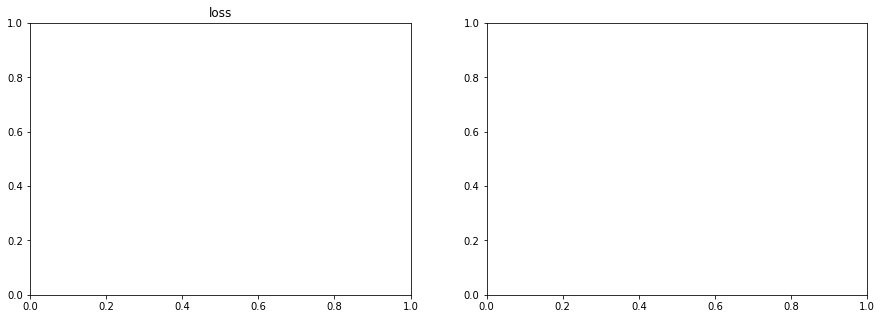

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(culture_hist.epoch, culture_hist.history["loss"], label="culture train loss")
ax[0].plot(culture_hist.epoch, culture_hist.history["val_loss"], label="culture validation loss")
ax[1].set_title('f2')
ax[1].plot(culture_hist.epoch, culture_hist.history["f2"], label="culture train F2")
ax[1].plot(culture_hist.epoch, culture_hist.history["val_f2"], label="culture validation F2")
ax[0].legend()
ax[1].legend()

In [ ]:
fig2, ax2 = plt.subplots(1, 2, figsize=(15,5))
ax2[0].set_title('loss')
ax2[0].plot(tag_hist.epoch, tag_hist.history["loss"], label="tag train loss")
ax2[0].plot(tag_hist.epoch, tag_hist.history["val_loss"], label="tag validation loss")
ax2[1].set_title('f2')
ax2[1].plot(tag_hist.epoch, tag_hist.history["f2"], label="tag train F2")
ax2[1].plot(tag_hist.epoch, tag_hist.history["val_f2"], label="tag validation F2")
ax2[0].legend()
ax2[1].legend()

In [28]:
print(os.listdir('../working/'))
culture_model.load_weights(checkpoint_file)
tag_model.load_weights(checkpoint_file2)

['training_log.csv', 'training_log2.csv', '.ipynb_checkpoints', '__notebook_source__.ipynb']


OSError: Unable to open file (unable to open file: name = '../working/resnet50_focal.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
'''Search for the best threshold regarding the CULTURE validation set'''

BATCH = 512
fullCultureValGen = data_generator.create_valid(
    culture_train_dataset_info[culture_valid_indexes], BATCH, (SIZE,SIZE,3), N_CULTURE_CLASSES)

n_val = round(culture_train_dataset_info.shape[0]*0.15)//BATCH
print(n_val)

lastFullCultureValPred = np.empty((0, N_CULTURE_CLASSES))
lastFullCultureValLabels = np.empty((0, N_CULTURE_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullCultureValGen)
    scores = culture_model.predict(im)
    lastFullCultureValPred = np.append(lastFullCultureValPred, scores, axis=0)
    lastFullCultureValLabels = np.append(lastFullCultureValLabels, lbl, axis=0)
print(lastFullCultureValPred.shape, lastFullCultureValLabels.shape)

In [ ]:
'''Search for the best threshold regarding the TAG validation set'''

BATCH = 512
fullTagValGen = data_generator.create_valid(
    tag_train_dataset_info[tag_valid_indexes], BATCH, (SIZE,SIZE,3), N_TAG_CLASSES)

n_val = round(tag_train_dataset_info.shape[0]*0.15)//BATCH
print(n_val)

lastFullTagValPred = np.empty((0, N_TAG_CLASSES))
lastFullTagValLabels = np.empty((0, N_TAG_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullTagValGen)
    scores = tag_model.predict(im)
    lastFullTagValPred = np.append(lastFullTagValPred, scores, axis=0)
    lastFullTagValLabels = np.append(lastFullTagValLabels, lbl, axis=0)
print(lastFullTagValPred.shape, lastFullTagValLabels.shape)

In [ ]:
def my_f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1), axis=1)
    tn = np.sum((y_true == 0) & (y_pred == 0), axis=1)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=1)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return np.mean(f2)

def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

In [ ]:
best_culture_thr, best_culture_score = find_best_fixed_threshold(lastFullCultureValPred, lastFullCultureValLabels, do_plot=True)
best_tag_thr, best_tag_score = find_best_fixed_threshold(lastFullTagValPred, lastFullTagValLabels, do_plot=True)

In [ ]:
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
predicted = []

for i, name in tqdm(enumerate(submit['id'])):
    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    label_predict = []
        
    # X-TOP method, started with C:2 and T:5, should down to C:1 and T:4
    #TODO: change this to Threshold method (0.130) and get as many labels as the model estimates surpassing the threshold
    culture_score_predict = culture_model.predict(preprocess_input(image[np.newaxis]))
    culture_indexes = np.arange(N_CULTURE_CLASSES)[culture_score_predict[0]>=best_culture_thr]
        
    tag_score_predict = tag_model.predict(preprocess_input(image[np.newaxis]))
    tag_indexes = np.arange(N_CULTURE_CLASSES,N_CULTURE_CLASSES+N_TAG_CLASSES)[tag_score_predict[0]>=best_tag_thr]
    
    label_predict = np.append(culture_indexes,tag_indexes)
    
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

In [ ]:
submit['attribute_ids'] = predicted
if POST_PROCESS:
    submit.to_csv('submission_not_process.csv', index=False)
else:
    submit.to_csv('submission.csv', index=False)